In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import chi2
pd.set_option("display.precision", 3)

In [2]:
np.set_printoptions(precision=4)

In [3]:
url_ff5 = "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
url_ffm = "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
url_pfo_25 = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/25_Portfolios_ME_Prior_12_2_CSV.zip"


def get_data(url, skiprows, nrows):
    return pd.read_csv(
        url,
        compression="zip",
        skiprows=skiprows,
        nrows=nrows,
        index_col=0,
        parse_dates=True,
        date_format="%Y%m"
    )["1963-07":]

ff5 = get_data(url_ff5, skiprows=3, nrows=728)
ffm = get_data(url_ffm, skiprows=13, nrows=1166)
ffm.rename(columns={'Mom   ': 'Mom'}, inplace=True)
pfo_25 = get_data(url_pfo_25, skiprows=11, nrows=1166)

In [4]:
def OLS_fit(X,Y,intercept=True):
    if intercept:
        X = sm.add_constant(X)
    return sm.OLS(Y,X).fit()
    
class Factor_Analysis:
    def __init__(self, Rm, Rf):
        self.Rm = Rm.to_numpy()
        self.Rf = Rf.to_numpy()
    
    def CAPM_Regress(self, R_asset, intercept = True):
        Y = R_asset - self.Rf
        X = self.Rm
        return OLS_fit(X,Y.to_numpy(),intercept=intercept)

    def init_FAMA(self,SMB,HML,MOM):
        self.SMB = SMB.to_numpy()
        self.HML = HML.to_numpy()
        self.MOM = MOM.to_numpy()

    def FFC_Regress(self,R_asset,intercept = True):
        Y = R_asset - self.Rf
        M_e = self.Rm
        X = np.column_stack([M_e,self.SMB,self.HML,self.MOM])
        OLS = OLS_fit(X,Y.to_numpy(),intercept = intercept)
        return OLS

def GRS_test(residuals,alpha,Mkt_excess):
    T = residuals.shape[0]
    cov = np.cov(residuals.T)
    SR = np.mean(Mkt_excess)/np.std(Mkt_excess)
    statistic = T*(alpha.T @ np.linalg.inv(cov) @ alpha)/(1 + SR**2)
    p_value = 1 - chi2.cdf(statistic,df=residuals.shape[1])
    return p_value,statistic

In [5]:
CAPM_analysis = Factor_Analysis(ff5["Mkt-RF"],ff5["RF"])
assets = pfo_25.columns
CAPM_regressions = [CAPM_analysis.CAPM_Regress(pfo_25[asset]) for asset in assets]
CAPM_alphas = [CAPM_regression.params[0] for CAPM_regression in CAPM_regressions]
CAPM_betas = [CAPM_regression.params[1] for CAPM_regression in CAPM_regressions]
CAPM_residuals = np.hstack([CAPM_regression.resid.reshape(-1,1) for CAPM_regression in CAPM_regressions])
pvals = np.array([regression.pvalues for regression in CAPM_regressions])
tvals = np.array([regression.tvalues for regression in CAPM_regressions])
bses = np.array([regression.bse for regression in CAPM_regressions])

In [6]:
columns=['asset','Alpha','Alpha_SE','Beta','Beta_SE','Alpha_t','Alpha_p','beta_t','beta_p']
df_rows = []
for i in range(len(assets)):
    data_req = [assets[i],CAPM_alphas[i],bses[i][0],CAPM_betas[i],bses[i][1],tvals[i][0],pvals[i][0],tvals[i][1],pvals[i][1]]
    dict_req = {k:v for k,v in zip(columns,data_req)}
    df_rows.append(dict_req)
df_req = pd.DataFrame(df_rows)
df_req

,asset,Alpha,Alpha_SE,Beta,Beta_SE,Alpha_t,Alpha_p,beta_t,beta_p
0,SMALL LoPRIOR,-0.719,0.199,1.410,0.044,-3.610,3.269e-04,32.044,4.254e-141
1,ME1 PRIOR2,0.069,0.134,1.059,0.030,0.519,6.040e-01,35.900,4.458e-163
2,ME1 PRIOR3,0.312,0.119,0.986,0.026,2.613,9.159e-03,37.408,1.667e-171
3,ME1 PRIOR4,0.454,0.122,0.993,0.027,3.729,2.071e-04,36.904,1.064e-168
4,SMALL HiPRIOR,0.606,0.154,1.196,0.034,3.947,8.679e-05,35.257,1.895e-159
5,ME2 PRIOR1,-0.635,0.168,1.473,0.037,-3.781,1.689e-04,39.719,3.326e-184
6,ME2 PRIOR2,0.047,0.117,1.135,0.026,0.399,6.903e-01,44.023,3.910e-207
7,ME2 PRIOR3,0.245,0.099,1.038,0.022,2.464,1.398e-02,47.298,6.438e-224
8,ME2 PRIOR4,0.393,0.102,1.059,0.023,3.854,1.264e-04,47.023,1.572e-222
9,ME2 PRIOR5,0.493,0.136,1.276,0.030,3.633,3.002e-04,42.585,1.391e-199


In [7]:
alpha_p, alpha_t = pvals[:,0], tvals[:,0]
print("Testing statistical significance, p-value < 0.05")
for i in range(len(assets)):
    if alpha_p[i] <= 0.05:
        print(f"{assets[i]}")

Testing statistical significance, p-value < 0.05
SMALL LoPRIOR
ME1 PRIOR3
ME1 PRIOR4
SMALL HiPRIOR
ME2 PRIOR1
ME2 PRIOR3
ME2 PRIOR4
ME2 PRIOR5
ME3 PRIOR1
ME3 PRIOR4
ME3 PRIOR5
ME4 PRIOR1
ME4 PRIOR4
ME4 PRIOR5
BIG LoPRIOR
BIG HiPRIOR


In [8]:
print("Testing economic significance, t-value > 2.5")
for i in range(len(assets)):
    if alpha_t[i] > 2.5:
        print(f"{assets[i]}")

Testing economic significance, t-value > 2.5
ME1 PRIOR3
ME1 PRIOR4
SMALL HiPRIOR
ME2 PRIOR4
ME2 PRIOR5
ME3 PRIOR5
ME4 PRIOR4
ME4 PRIOR5
BIG HiPRIOR


In [9]:
pval,GRS_stat = GRS_test(CAPM_residuals,np.array(CAPM_alphas).reshape(-1,1),ff5["Mkt-RF"].to_numpy())
print(f"GRS test statistic: {GRS_stat[0][0]}, P-value: {pval[0][0]}")

GRS test statistic: 128.36211917417407, P-value: 7.771561172376096e-16


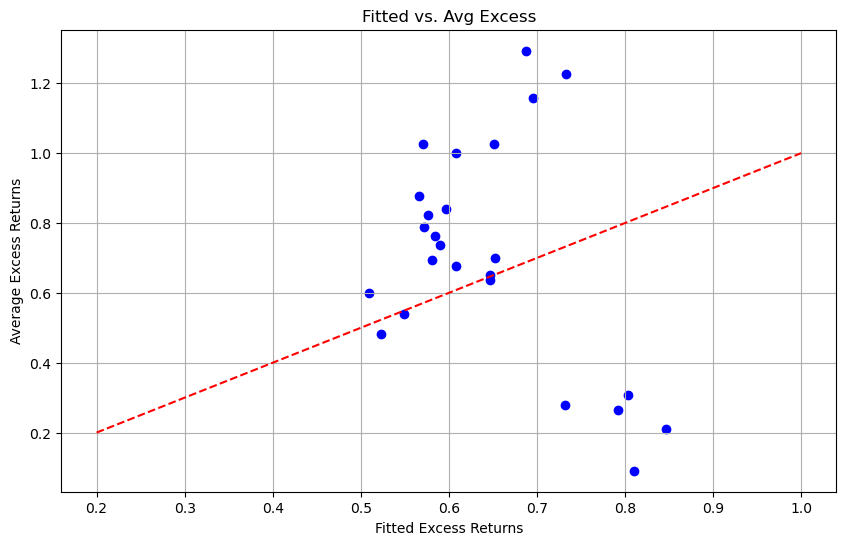

In [10]:
avg_excess = pfo_25.mean().to_numpy() - np.mean(ff5["RF"].to_numpy())
avg_mkt_excess = ff5["Mkt-RF"].mean()
fitted_excess = np.array([beta*avg_mkt_excess for beta in CAPM_betas])
plt.figure(figsize=(10, 6))
plt.scatter(fitted_excess, avg_excess, color='blue')
plt.title('Fitted vs. Avg Excess')
plt.xlabel('Fitted Excess Returns')
plt.ylabel('Average Excess Returns')
plt.grid()
plt.plot([0.2, 1], [0.2, 1], 'r--')
plt.show()

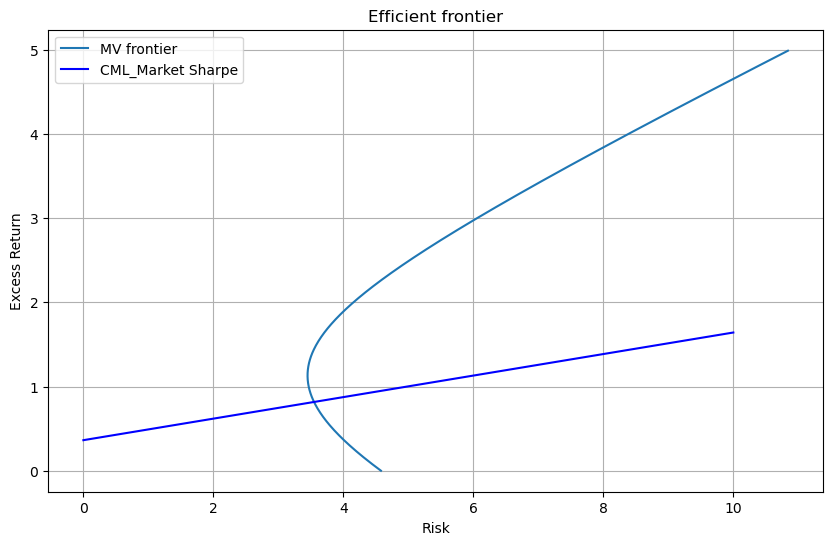

In [11]:
import cvxpy as cp
def mean_variance_optimization(mean,cov,targ):
    n = len(mean)
    # Define variables
    alpha = cp.Variable(n)
    # Define problem
    ret = mean.T @ alpha
    risk = cp.quad_form(alpha, cov)
    prob = cp.Problem(cp.Minimize(risk), [cp.sum(ret) == targ,cp.sum(alpha) == 1])
    prob.solve()
    return alpha.value

mu_exp = pfo_25.mean().to_numpy()
cov = pfo_25.cov().to_numpy()
target_returns = np.arange(0,5,0.01)
var = []
mkt_sharpe = np.mean(ff5["Mkt-RF"].to_numpy())/np.std(ff5["Mkt-RF"].to_numpy())
for targ in target_returns:
    alpha = mean_variance_optimization(mu_exp,cov,targ).reshape(-1,1)
    var.append(np.sqrt(alpha.T @ cov @ alpha))

plt.figure(figsize=(10, 6))
plt.plot(np.array(var).reshape(-1,1), target_returns, label = 'MV frontier')
plt.plot([0,10],[ff5['RF'].mean(),ff5['RF'].mean()+mkt_sharpe*10],label='CML_Market Sharpe',c='b')
plt.title('Efficient frontier')
plt.xlabel('Risk')
plt.ylabel('Excess Return')
plt.grid()
plt.legend()
plt.show()

### CAPM commentary

- Based on printed t-statisitcs and p-values, we can see that the $\beta$'s are very far away from $0$ implying that all assets have a component in the direction of the market
- Clearly, we can see a bunch of assets(~$16/25$) with p-value $< 0.05$ implying that we can safely reject the Null of $\alpha_i=0$
- The GRS statistic also says that we can reject the hypothesis of all $\alpha_i$ are jointly $0$
- One can also note that there are ~$9$ assets with economic significance i.e., the $\alpha$ values are so high that the t-stat is $>2.5$
- As a result, we can see that CAPM is not the best way to model this due to presence of a significant amount of value in the bias term when excess returns are regressed
- This is also evident from the scatter plot above where in an ideal CAPM setting, the points should lie close to a $y=mx$ line whereas in reality they are quite far away
- The plot of mean variance frontier for the given set of portfolios also adds more color to the situation as we can see that the CML line, which should be tangential to the frontier, is below the efficient frontier which signifies the effect of pricing errors
- Based on the above observations, we can say that CAPM fails to explain the behavior of assets due to the presence of statistically significant pricing errors

### Q5

In [12]:
FFC_Analysis = Factor_Analysis(ff5["Mkt-RF"],ff5["RF"])
FFC_Analysis.init_FAMA(ff5["SMB"],ff5["HML"],ffm["Mom"])
assets = pfo_25.columns
FFC_regressions = [FFC_Analysis.FFC_Regress(pfo_25[asset]) for asset in assets]
FFC_alphas = np.array([Regression.params[0] for Regression in FFC_regressions])
FFC_betas = np.array([Regression.params[1:] for Regression in FFC_regressions])
FFC_residuals = np.hstack([FFC_regression.resid.reshape(-1,1) for FFC_regression in FFC_regressions])
pvals = np.array([regression.pvalues for regression in FFC_regressions])
tvals = np.array([regression.tvalues for regression in FFC_regressions])
bses = np.array([regression.bse for regression in FFC_regressions])

In [13]:
columns=['asset','Alpha','Alpha_SE','Betas(Mkt,SMB,HML,MOM)','Beta_SEs(Mkt,SMB,HML,MOM)','Alpha_t','Alpha_p','beta_ts(Mkt,SMB,HML,MOM)','beta_ps(Mkt,SMB,HML,MOM)']
df_rows = []
for i in range(len(assets)):
    data_req = [assets[i],np.round(FFC_alphas[i],3),bses[i][0],np.round(FFC_betas[i],3),np.round(bses[i][1:],3),np.round(tvals[i][0],3),np.round(pvals[i][0],3),np.round(tvals[i][1],3),np.round(pvals[i][1:],3)]
    dict_req = {k:v for k,v in zip(columns,data_req)}
    df_rows.append(dict_req)
df_req = pd.DataFrame(df_rows)
df_req

,asset,Alpha,Alpha_SE,"Betas(Mkt,SMB,HML,MOM)","Beta_SEs(Mkt,SMB,HML,MOM)",Alpha_t,Alpha_p,"beta_ts(Mkt,SMB,HML,MOM)","beta_ps(Mkt,SMB,HML,MOM)"
0,SMALL LoPRIOR,-0.355,0.097,"[1.059, 1.263, -0.02, -0.679]","[0.023, 0.032, 0.033, 0.023]",-3.652,0.000,46.542,"[0.0, 0.0, 0.551, 0.0]"
1,ME1 PRIOR2,0.054,0.058,"[0.871, 0.976, 0.259, -0.245]","[0.014, 0.019, 0.02, 0.014]",0.931,0.352,63.779,"[0.0, 0.0, 0.0, 0.0]"
2,ME1 PRIOR3,0.162,0.057,"[0.849, 0.889, 0.305, -0.065]","[0.013, 0.019, 0.019, 0.014]",2.833,0.005,63.483,"[0.0, 0.0, 0.0, 0.0]"
3,ME1 PRIOR4,0.204,0.061,"[0.87, 0.925, 0.276, 0.088]","[0.014, 0.02, 0.021, 0.015]",3.331,0.001,60.655,"[0.0, 0.0, 0.0, 0.0]"
4,SMALL HiPRIOR,0.270,0.076,"[1.026, 1.173, 0.038, 0.298]","[0.018, 0.025, 0.026, 0.018]",3.545,0.000,57.474,"[0.0, 0.0, 0.143, 0.0]"
5,ME2 PRIOR1,-0.207,0.069,"[1.167, 0.971, -0.058, -0.71]","[0.016, 0.023, 0.024, 0.017]",-2.989,0.003,71.998,"[0.0, 0.0, 0.014, 0.0]"
6,ME2 PRIOR2,0.115,0.056,"[0.965, 0.781, 0.188, -0.3]","[0.013, 0.018, 0.019, 0.013]",2.071,0.039,74.093,"[0.0, 0.0, 0.0, 0.0]"
7,ME2 PRIOR3,0.118,0.053,"[0.933, 0.701, 0.271, -0.055]","[0.012, 0.018, 0.018, 0.013]",2.220,0.027,74.862,"[0.0, 0.0, 0.0, 0.0]"
8,ME2 PRIOR4,0.168,0.051,"[0.962, 0.765, 0.255, 0.084]","[0.012, 0.017, 0.017, 0.012]",3.274,0.001,80.128,"[0.0, 0.0, 0.0, 0.0]"
9,ME2 PRIOR5,0.144,0.064,"[1.144, 0.993, -0.012, 0.366]","[0.015, 0.021, 0.022, 0.015]",2.266,0.024,76.762,"[0.0, 0.0, 0.571, 0.0]"


In [14]:
alpha_p, alpha_t = pvals[:,0], tvals[:,0]
print("Testing statistical significance, p-value < 0.05")
for i in range(len(assets)):
    if alpha_p[i] <= 0.05:
        print(f"{assets[i]}")

Testing statistical significance, p-value < 0.05
SMALL LoPRIOR
ME1 PRIOR3
ME1 PRIOR4
SMALL HiPRIOR
ME2 PRIOR1
ME2 PRIOR2
ME2 PRIOR3
ME2 PRIOR4
ME2 PRIOR5
ME3 PRIOR5
ME4 PRIOR2
ME5 PRIOR2


In [15]:
print("Testing economic significance, t-value > 2.5")
for i in range(len(assets)):
    if alpha_t[i] > 2.5:
        print(f"{assets[i]}")

Testing economic significance, t-value > 2.5
ME1 PRIOR3
ME1 PRIOR4
SMALL HiPRIOR
ME2 PRIOR4
ME4 PRIOR2
ME5 PRIOR2


In [16]:
pval,GRS_stat = GRS_test(FFC_residuals,np.array(FFC_alphas).reshape(-1,1),ff5["Mkt-RF"].to_numpy())
print(f"GRS test statistic: {GRS_stat[0][0]}, P-value: {pval[0][0]}")

GRS test statistic: 105.21182214002464, P-value: 8.195333300875518e-12


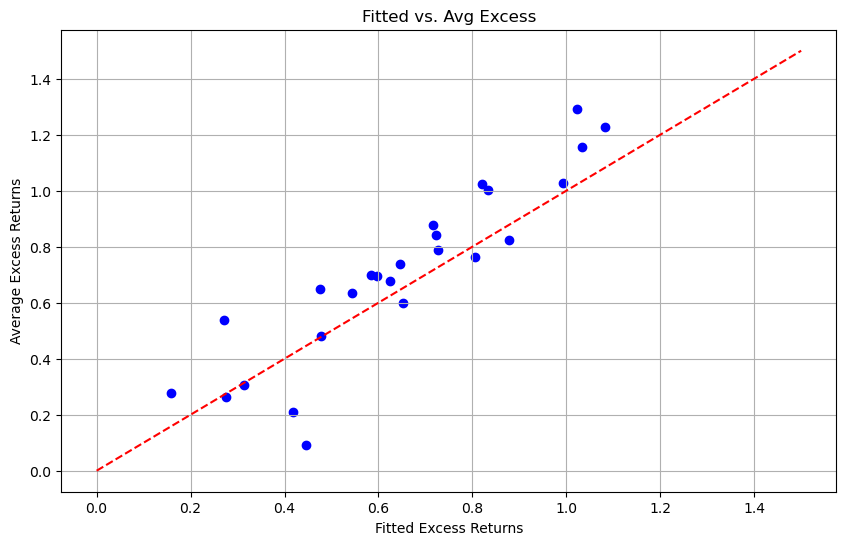

In [17]:
avg_excess = pfo_25.mean().to_numpy() - np.mean(ff5["RF"].to_numpy())
avg_mkt_excess = ff5["Mkt-RF"].mean()
avg_SMB = ff5["SMB"].mean()
avg_HML = ff5["HML"].mean()
avg_MOM = ffm["Mom"].mean()
indep = np.array([avg_mkt_excess,avg_SMB,avg_HML,avg_MOM])
fitted_excess = np.array([beta @ indep for beta in FFC_betas])
plt.figure(figsize=(10, 6))
plt.scatter(fitted_excess, avg_excess, color='blue')
plt.title('Fitted vs. Avg Excess')
plt.xlabel('Fitted Excess Returns')
plt.ylabel('Average Excess Returns')
plt.grid()
plt.plot([0, 1.5], [0, 1.5], 'r--')
plt.show()

### Observations under FFC model

- We can see dip in the number of statistically significant $\alpha$'s from $16$ to $12$ compared to CAPM which implies a reduction in the number of pricing errors
- The plot above further proves the point as the scatter plot may not be truly on $y=mx$, we can see lot more points closers to it
- GRS test implies that there are $\alpha$'s which are jointly $0$ but the amount of pricing error is low in this case
- We could also see a reduction in the number of economically significant errors
- In summary, FFC $4$ Factor model is better than using CAPM

In [18]:
cross_section_grp = pfo_25.mean().to_numpy() - np.mean(ff5["RF"].to_numpy())
cross_regression = OLS_fit(FFC_betas,cross_section_grp,intercept=False)
print(cross_regression.summary())
theoretical_risk_prem = [ff5["Mkt-RF"].mean(),ff5["SMB"].mean(),ff5["HML"].mean(),ffm["Mom"].mean()]
estim_risk_prem = cross_regression.params
print("Theoretical Risk premia: ", np.round(theoretical_risk_prem,3))
print("Estimated Risk premia: ", np.round(estim_risk_prem,3))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              216.4
Date:                Mon, 22 Apr 2024   Prob (F-statistic):                    9.64e-17
Time:                        20:24:34   Log-Likelihood:                          17.731
No. Observations:                  25   AIC:                                     -27.46
Df Residuals:                      21   BIC:                                     -22.59
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

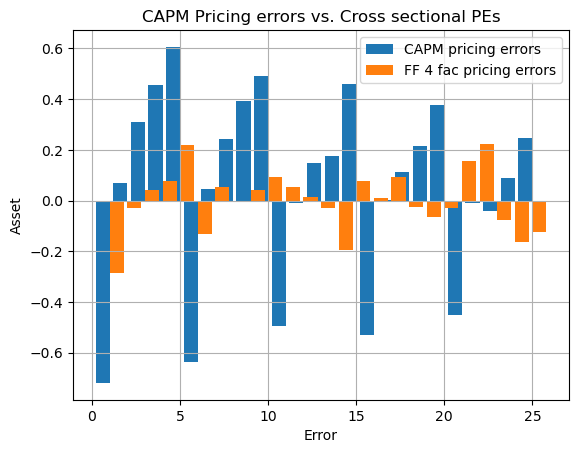

In [19]:
plt.bar([i - 0.4 for i in range(1,26)], CAPM_alphas, label = 'CAPM pricing errors')
plt.bar([i + 0.4 for i in range(1,26)], cross_regression.resid, label = 'FF 4 fac pricing errors')
plt.title('CAPM Pricing errors vs. Cross sectional PEs')
plt.xlabel('Error')
plt.ylabel('Asset')
plt.grid()
plt.legend()

### Cross sectional regression observations

- Apart from the $\lambda_{HML}$, all estimated lambdas are close to the implied risk premia
- The t-stats also imply a good amount of statistical significance for each of them implying the regression depends on all the individual factors
- Also when we compare the pricing errors, we can see that in case of cross sectional regression, the PEs are significantly smaller than the CAPM ones in the above plot as $y$ axis ranges in $(-0.3,0.2)$ while $x$ axis ranges in $(-0.7,0.6)$

In [20]:
corners = ['SMALL LoPRIOR', 'SMALL HiPRIOR', 'BIG LoPRIOR', 'BIG HiPRIOR']
window_size = 60
betas = []
for i in range(len(pfo_25)-window_size):
    FFC_Analysis = Factor_Analysis(ff5["Mkt-RF"][i:i+window_size],ff5["RF"][i:i+window_size])
    FFC_Analysis.init_FAMA(ff5["SMB"][i:i+window_size],ff5["HML"][i:i+window_size],ffm["Mom"][i:i+window_size])
    assets = pfo_25.columns
    FFC_regressions = [FFC_Analysis.FFC_Regress(pfo_25[asset][i:i+window_size]) for asset in corners]
    betas.append(np.array([Regression.params[1:] for Regression in FFC_regressions]))

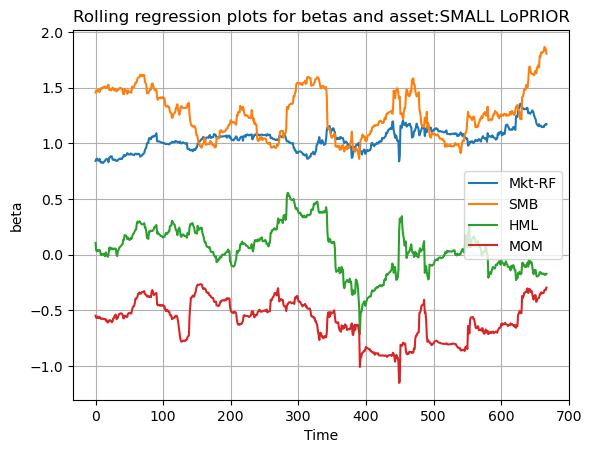

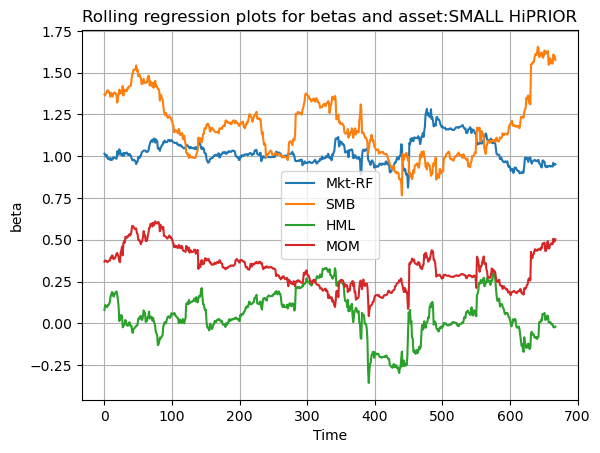

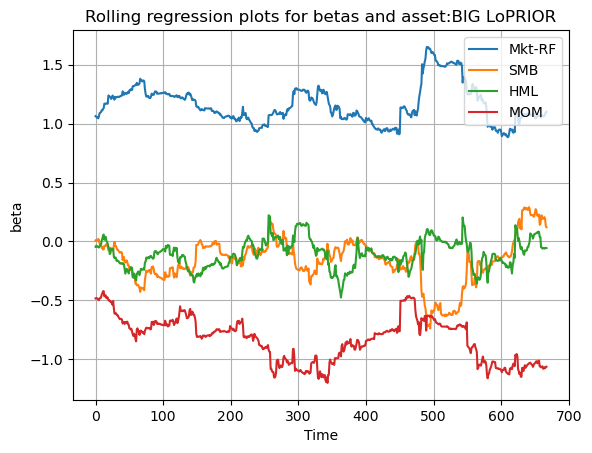

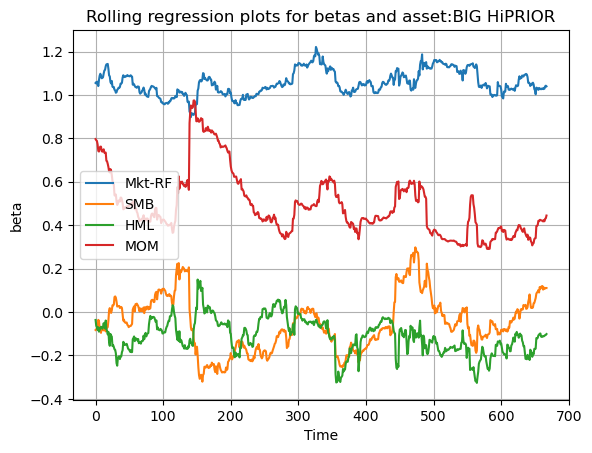

In [21]:
betas = np.array(betas)
for i in range(len(corners)):
    plt.plot(betas[:,i,0],label = "Mkt-RF")
    plt.plot(betas[:,i,1], label = "SMB")
    plt.plot(betas[:,i,2], label = "HML")
    plt.plot(betas[:,i,3], label = "MOM")
    plt.title(f'Rolling regression plots for betas and asset:{corners[i]}')
    plt.xlabel('Time')
    plt.ylabel('beta')
    plt.grid()
    plt.legend()
    plt.show()

One can see that the beta's do change over time and tend to follow some form of pattern

### FF Macbeth

In [22]:
window_size = 60
cross_sect_reg = []
for i in range(len(pfo_25)-59):
    FFC_Analysis = Factor_Analysis(ff5["Mkt-RF"][i:i+window_size],ff5["RF"][i:i+window_size])
    FFC_Analysis.init_FAMA(ff5["SMB"][i:i+window_size],ff5["HML"][i:i+window_size],ffm["Mom"][i:i+window_size])
    assets = pfo_25.columns
    FFC_regressions = [FFC_Analysis.FFC_Regress(pfo_25[asset][i:i+window_size]) for asset in assets]
    FFC_alphas = np.array([Regression.params[0] for Regression in FFC_regressions])
    FFC_betas = np.array([Regression.params[1:] for Regression in FFC_regressions])
    cross_section_grp = pfo_25[i:i+window_size].mean().to_numpy()- np.mean(ff5["RF"][i:i+window_size].to_numpy())
    cross_regression = OLS_fit(FFC_betas,cross_section_grp,intercept=False)
    cross_sect_reg.append(cross_regression)

In [24]:
df_summary = pd.DataFrame(columns=['Mkt-RF','SMB','HML','MoM'])
reg_params = np.array([regression.params for regression in cross_sect_reg])
df_summary.loc["coef"] = np.mean(reg_params,axis=0)
df_summary.loc["SE"] = np.std(reg_params,axis=0)/np.sqrt(len(reg_params))
df_summary.loc["T-Vals"] = df_summary.loc["coef"]/df_summary.loc["SE"]
df_summary

,Mkt-RF,SMB,HML,MoM
coef,0.626,0.192,0.254,0.671
SE,0.020,0.022,0.024,0.020
T-Vals,31.369,8.669,10.692,33.866


In [25]:
theoretical_risk_prem = [ff5["Mkt-RF"].mean(),ff5["SMB"].mean(),ff5["HML"].mean(),ffm["Mom"].mean()]
estim_risk_prem = cross_regression.params
FFM_rik_prem = np.mean(reg_params,axis=0)
print("Theoretical Risk premia: ", np.round(theoretical_risk_prem,3))
print("FFM  factor Risk premia: ", np.round(FFM_rik_prem,3))
print("FF 4 factor Risk premia: ", np.round(estim_risk_prem,3))

Theoretical Risk premia:  [0.574 0.205 0.283 0.612]
FFM  factor Risk premia:  [0.626 0.192 0.254 0.671]
FF 4 factor Risk premia:  [ 1.1   -0.261 -0.041  0.354]


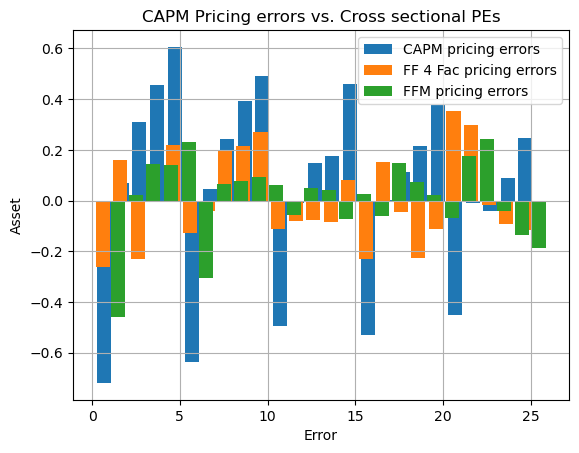

In [26]:
residuals = np.array([regression.resid.reshape(-1,) for regression in cross_sect_reg])
mean_residuals = np.mean(residuals, axis = 0)
plt.bar([i - 0.3 for i in range(1,26)], CAPM_alphas, label = 'CAPM pricing errors')
plt.bar([i - 0.4 for i in range(1,26)], cross_regression.resid, label = 'FF 4 Fac pricing errors')
plt.bar([i + 0.5 for i in range(1,26)], mean_residuals, label = 'FFM pricing errors')

plt.title('CAPM Pricing errors vs. Cross sectional PEs')
plt.xlabel('Error')
plt.ylabel('Asset')
plt.grid()
plt.legend()

### Observations for FF Macbeth

- We can see that the coefficients in FF macbeth rolling regression are closer to the theoretical implied risk premia even for HML which is in contrast with FF $4$ factor model. This can be due to some temporal dependencies in HML data which wasn't captured in the $4$ factor approach as it looks across all time stamps
- The pricing errors are also better in FFM case apart from few assets where the FF $4$ factor model beats the rolling approach
- Also it goes without saying that the FFM coefficients are all statistically significant
- As for corner portfolios, we would get the same results as the rolling windows are same